# Video 2 : Creating a Basic Review Classification Model

- The MultinomialNB classifier is suitable for classifying text data where features represent counts of words or other discrete elements. 
- Where as Bernoulli naive bayes is used when you only when the features represent the presence or absence of the words as in case of one hot encoding.

In [1]:
import nltk
import pandas as pd
import numpy as np
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abarhouche\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\abarhouche\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abarhouche\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# read the dataset
# the data was already split into train, validation, and test and randomized so no need to do it again
train = pd.read_csv('../Data/train.csv')
validation = pd.read_csv('../Data/validation.csv')
test = pd.read_csv('../Data/test.csv')

In [4]:
train.shape, validation.shape, test.shape

((17877, 5), (3831, 5), (3831, 5))

In [5]:
# view the train data
train.head()

,review_id,title,year,user_review,user_suggestion
0,460,Black Squad,2018.0,"Early Access ReviewVery great shooter, that ha...",1
1,2166,Tree of Savior (English Ver.),2016.0,I love love love playing this game!Super 100%!...,1
2,17242,Eternal Card Game,2016.0,Early Access ReviewAs a fan of MTG and Hearths...,1
3,6959,Tactical Monsters Rumble Arena,2018.0,Turn based strategy game similiar to FF Tactic...,1
4,8807,Yu-Gi-Oh! Duel Links,2017.0,This game has an insanely huge download for be...,0


In [6]:
# view the test data
test.head()

,review_id,title,year,user_review,user_suggestion
0,12053,Infestation: The New Z,2016.0,Unbelievable that this rehash copy and paste t...,0
1,12536,SMITE®,2015.0,I can't recommened this game in its current st...,0
2,747,Heroes & Generals,2016.0,Early Access ReviewThis game is constantly evo...,0
3,3214,World of Warships,2018.0,I play this game because it scratches an itch....,0
4,4036,World of Guns: Gun Disassembly,2016.0,"Finally, a game for people like us to enjoy! P...",1


In [7]:
# view the valodation data
validation.head()

,review_id,title,year,user_review,user_suggestion
0,8604,Dungeon Defenders II,2015.0,Early Access Review* Ok Played the first DD lo...,1
1,20407,Minion Masters,2017.0,Product received for freeEarly Access ReviewSo...,1
2,636,Magic Duels,2018.0,Game is extremely unfun to play unless you wan...,0
3,10217,Robocraft,2016.0,Early Access ReviewThis used to be an amazing ...,0
4,9564,Realm of the Mad God,2014.0,"With stunning visuals, an immersive storyline,...",1


In [8]:
test['user_suggestion'].value_counts()

user_suggestion
1    2187
0    1644
Name: count, dtype: int64

In [9]:
# Load the SpaCy English model
# Since we are not using NER, we can disable it to speedup
nlp = spacy.load("en_core_web_sm", disable='ner')

### Preprocessing Function

In [10]:
def preprocess_text(texts):
    # lemmatize the tokens and store them in a list
    processed_texts = []
    for doc in nlp.pipe(texts, n_process=-1):
        lemmatized_tokens = [token.lemma_.lower() for token in doc if token.is_alpha and token.lemma_ not in nlp.Defaults.stop_words]
        
        # Join the lemmatized tokens into a string
        processed_text = " ".join(lemmatized_tokens)
        
        processed_texts.append(processed_text)
        
    return processed_texts

### Explanation
This function preprocesses a list of texts using spaCy. Here's a breakdown:

1. Initialization: It creates an empty list processed_texts to store the processed versions of the input texts.
2. Looping: It iterates through the input texts using spaCy's nlp.pipe method with n_process=-1 for multi-core processing (if available).
3. Lemmatization and Stopword Removal: For each text (as a spaCy doc object):
    - It extracts the tokens (words).
    - It lemmatizes each token, converting words to their base form ("running" becomes "run").
    - It converts all tokens to lowercase.
    - The is_alpha attribute makes sure that only alpha numeric tokens are considered.
    - It removes stop words like "the" and "a" (using nlp.Defaults.stop_words).
4. Text Joining: It joins the remaining lemmatized tokens back into a single string.
5. Storage: It appends the processed text to the processed_texts list.
6. Return: Finally, the function returns the list of preprocessed texts.

In [11]:
# apply preprotcess_text function to user_review column
train['user_review'] = preprocess_text(train['user_review'])
validation['user_review'] = preprocess_text(validation['user_review'])
test['user_review'] = preprocess_text(test['user_review'])

In [12]:
#view the first 5 rows
train['user_review'].head()

0    early access reviewvery great shooter original...
1    i love love love play lot class choose bound s...
2    early access reviewas fan mtg hearthstone fun ...
3    turn base strategy game similiar ff tactic day...
4    game insanely huge download phone game blast v...
Name: user_review, dtype: object

### Vectorization

#### OHE

- In our case we have set min_df = 0.001, that is any word which does not appear in more than 0.1% documents or reviews will not be considered in the internal vocabulary being created by count vectorizer. Feel free to change this value as this is a hyperparameter which requires tuning.

In [13]:
count_vectorizer_ohe = CountVectorizer(min_df=0.001, binary=True)

In [14]:
#fit_transform user_review
count_vectorizer_ohe_train = count_vectorizer_ohe.fit_transform(train['user_review'])

#### Building a Naive Bayes Model

In [15]:
# Naive Bayes Classifier
naive_bayes_classifier = BernoulliNB()

In [16]:
#create the naive bayes model for the train data
naive_bayes_classifier.fit(count_vectorizer_ohe_train, train['user_suggestion'])
naive_bayes_classifier.score(count_vectorizer_ohe_train, train['user_suggestion'])

0.825585948425351

In [17]:
##create the naive bayes model for the validation data
count_vectorizer_ohe_val = count_vectorizer_ohe.transform(validation['user_review'])
naive_bayes_classifier.score(count_vectorizer_ohe_val, validation['user_suggestion'])

0.8120595144870791

#### Count Vectorizer

In [18]:
# initialize count_vectorizer and name it count_vectorizer
count_vectorizer = CountVectorizer(min_df=0.001)

In [19]:
#fit_transform user_review
count_vectorizer_train = count_vectorizer.fit_transform(train['user_review'])

#### Building a Naive Bayes Model using count vectorization

In [20]:
# Naive Bayes Classifier
naive_bayes_classifier = MultinomialNB()

In [21]:
#create the naive bayes model for the train data
naive_bayes_classifier.fit(count_vectorizer_train, train['user_suggestion'])
naive_bayes_classifier.score(count_vectorizer_train, train['user_suggestion'])

0.8388991441517033

In [22]:
##create the naive bayes model for the validation data
count_vectorizer_val = count_vectorizer.transform(validation['user_review'])
naive_bayes_classifier.score(count_vectorizer_val, validation['user_suggestion'])

0.8258940224484469

#### OHE vs Count Vectorization

Before we proceed, please note, by no means are we stating that count vectorizer is superior to one hot encoding. 
- The choice depends on whether understanding the relationship and frequency of words in the text is important.

- One-hot encoding typically requires less memory and computational power where as algorithms that leverage word frequency for predictive accuracy (e.g., Multinomial Naive Bayes generally perform better with Count Vectorizer).

# Video 3 : Understanding TF-IDF and its Implementation

In [23]:
# import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
# initialize tfifd vectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=0.001)

In [25]:
#create the naive bayes model for the train data using tfidf
tfidf_vectorizer_train = tfidf_vectorizer.fit_transform(train['user_review'])
naive_bayes_classifier.fit(tfidf_vectorizer_train, train['user_suggestion'])
naive_bayes_classifier.score(tfidf_vectorizer_train, train['user_suggestion'])

0.8411366560384852

In [26]:
#create the naive bayes model for the validation data using tfidf
tfidf_vectorizer_val = tfidf_vectorizer.transform(validation['user_review'])
naive_bayes_classifier.score(tfidf_vectorizer_val, validation['user_suggestion'])

0.8201513965022187

For example, in our sentence - "Life is very beatiful", the way the model interprets "beatiful" as an individual token and "very beautiful" as an indvidual token may impact the performance of the model.

# Video 4 - Using n-grams with TfIdf

In [27]:
tfidf_ngram_vectorizer = TfidfVectorizer(min_df=0.001, ngram_range=(1, 3))

#### Building Naive Bayes Model

In [28]:
#create the naive bayes model for the train data using tfidf and ngram
tfidf_ngram_vectorizer_train = tfidf_ngram_vectorizer.fit_transform(train['user_review'])
naive_bayes_classifier.fit(tfidf_ngram_vectorizer_train, train['user_suggestion'])
naive_bayes_classifier.score(tfidf_ngram_vectorizer_train, train['user_suggestion'])

0.859204564524249

In [29]:
tfidf_ngram_vectorizer.get_feature_names_out()[150:160]

array(['actually good', 'actually like', 'actually look', 'actually play',
       'actually play game', 'actually pretty', 'actually use',
       'actually want', 'actually work', 'actualy'], dtype=object)

In [30]:
#create the naive bayes model for the validation data using tfidf and ngram
tfidf_ngram_vectorizer_val = tfidf_ngram_vectorizer.transform(validation['user_review'])
naive_bayes_classifier.score(tfidf_ngram_vectorizer_val, validation['user_suggestion'])

0.8292873923257635

In [31]:
count_ngram_vectorizer = CountVectorizer(min_df=0.001, ngram_range=(1, 3))

In [32]:
#create the naive bayes model for the train data using count vectorizer and ngram
count_ngram_vectorizer_train = count_ngram_vectorizer.fit_transform(train['user_review'])
naive_bayes_classifier.fit(count_ngram_vectorizer_train, train['user_suggestion'])
naive_bayes_classifier.score(count_ngram_vectorizer_train, train['user_suggestion'])

0.8488560720478827

In [33]:
#create the naive bayes model for the validation data using count vectorizer and ngram
count_ngram_vectorizer_val = count_ngram_vectorizer.transform(validation['user_review'])
naive_bayes_classifier.score(count_ngram_vectorizer_val, validation['user_suggestion'])

0.8256329939963456

Again, a superior score does not mean count vectorizer is inferior to TFIDF. The choice between TF-IDF and count vectorizer hinges on:

- Document Uniqueness: TF-IDF emphasizes words that are unique to specific documents, making it ideal for tasks where document differentiation is key.
- Corpus Size and Diversity: TF-IDF performs better with large and diverse datasets by downplaying common words across documents.
- Relevance of Common Words: If frequent common words are informative for the analysis, count vectorizer might be more appropriate.

# Video 5: POS Tagging and NER

In [34]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

In [35]:
def preprocess_text_spacy(processed_texts):
    # Tokenization and POS tagging
    pos_texts = []
    for doc in nlp.pipe(processed_texts):
        pos_tags = [token.pos_ for token in doc]
        pos_text = " ".join(pos_tags)
        pos_texts.append(pos_text)

    # Named Entity Recognition (NER)
    ner_texts = []
    for doc in nlp.pipe(processed_texts):     
        ner_tags = [token.ent_type_ if token.ent_type_ else "O" for token in doc]
        ner_text = " ".join(ner_tags)
        ner_texts.append(ner_text)
    
    return [pos_texts, ner_texts]

#### Explanation-
Here's a breakdown of the code's functionality:

1. Tokenization and POS Tagging:

    - It creates an empty list pos_texts to store the part-of-speech (POS) tags.
    - It iterates over the processed_texts using nlp.pipe, which processes each text efficiently.
    - For each text, it extracts the POS tag for each token using token.pos_.
    - It joins the POS tags into a string and appends this string to the pos_texts list.

2. Named Entity Recognition (NER):

    - It creates an empty list ner_texts to store named entity tags.
    - A second iteration over the processed_texts using nlp.pipe processes each text again.
    - For each text, it extracts the entity type for each token using token.ent_type_.
    - If a token does not have an entity type, it assigns "O" (outside of any entity).
    - It joins the NER tags into a string and appends this string to the ner_texts list.

3. Returning Results:

    - The function returns a list containing two lists: pos_texts and ner_texts. These lists correspond to the POS           tags and NER tags for each text, respectively.

In [36]:
#applying preprocess_text_spacy function to user_review column for train data
pos_texts, ner_texts = preprocess_text_spacy(train['user_review'])

In [37]:
# adding the lists as column to the dataset
train['pos_tags'] = pos_texts
train['ner_tags'] = ner_texts

In [38]:
train.head()

,review_id,title,year,user_review,user_suggestion,pos_tags,ner_tags
0,460,Black Squad,2018.0,early access reviewvery great shooter original...,1,ADJ NOUN NOUN ADJ ADJ NOUN NOUN PROPN VERB NOU...,O O O O O O O O O O O O O O O O O O O O O O O ...
1,2166,Tree of Savior (English Ver.),2016.0,i love love love play lot class choose bound s...,1,PRON VERB NOUN NOUN NOUN NOUN NOUN VERB VERB A...,O O O O O O O O O O O O O O
2,17242,Eternal Card Game,2016.0,early access reviewas fan mtg hearthstone fun ...,1,ADJ NOUN VERB PROPN PROPN NOUN NOUN NOUN ADJ N...,O O O O O O O O O O O O O O O O O O O O
3,6959,Tactical Monsters Rumble Arena,2018.0,turn base strategy game similiar ff tactic day...,1,VERB NOUN NOUN NOUN ADJ ADJ NOUN NOUN VERB ADV...,O O O O O O DATE DATE O O O O O O O O O O O O ...
4,8807,Yu-Gi-Oh! Duel Links,2017.0,game insanely huge download phone game blast v...,0,NOUN ADV ADJ NOUN NOUN NOUN NOUN NOUN ADJ NOUN...,O O O O O O O O O O O O O O O


In [39]:
from spacy import displacy

text= train['user_review'][3]
text
doc = nlp(text)
displacy.render(doc, style="ent")

__India is a country with leading IT companies such as Infosys, TCS, Wipro etc. Most of them make millions of dollars in revenues and are based out of Hyderabad__

In [69]:
text1= "SABIS is the best school"
text1
doc = nlp(text1)
displacy.render(doc, style="ent")

In [41]:
del train['pos_tags']
del train['ner_tags']

In [42]:
def remove_noun(df):

  nlp = spacy.load("en_core_web_sm")  

  # Process user_review column
  filtered_reviews = []
  for review in df['user_review']:
    filtered_review = " ".join([token.text for token in nlp(review) if token.pos_ not in ['NOUN', 'PROPN']])
    filtered_reviews.append(filtered_review)
  
  return filtered_reviews

#### Explanation:

1. Function Definition:
    - The code defines a function named remove_noun that takes a DataFrame train as input.
    
2. spaCy Model Loading:
    - Loads the spaCy English language model (en_core_web_sm).

3. Processing user_review:
    - Similar to the previous code, it iterates over each review in the "user_review" column.
    - For each review, it uses nlp(review) to create a spaCy document object.
    - The list comprehension filters tokens by keeping only those with POS tags other than "NOUN" and "PROPN".
    - The remaining tokens are joined back into a single string which represents the filtered_reviews.
    - This filtered string is then appended to the list filtered_reviews.

5. Returning Results:
    - The function returns the list filtered_reviews, which contains the modified text of reviews with nouns and proper nouns removed.

In [43]:
w_noun_train  = remove_noun(train)

In [44]:
train['user_review'].head()

0    early access reviewvery great shooter original...
1    i love love love play lot class choose bound s...
2    early access reviewas fan mtg hearthstone fun ...
3    turn base strategy game similiar ff tactic day...
4    game insanely huge download phone game blast v...
Name: user_review, dtype: object

In [45]:
w_noun_train[:5]

['early great shooter understand visual look i think evolve sure early i think need cuz compare low think go i hope understand i like i think i',
 'i love choose bound storyline',
 'early reviewas far good know haha great',
 'turn similiar ff remember easy enjoyable different try bored want able play occasional',
 'insanely huge entire far long']

In [46]:
tfidf_wnoun_vectorizer = TfidfVectorizer(min_df=0.001)
tfidf_wnoun_vectorizer_train = tfidf_wnoun_vectorizer .fit_transform(w_noun_train)

In [47]:
# tfidf_wnoun_vectorizer_train =tfidf_wnoun_vectorizer .fit_transform(train['user_review'])
naive_bayes_classifier.fit(tfidf_wnoun_vectorizer_train , train['user_suggestion'])
naive_bayes_classifier.score(tfidf_wnoun_vectorizer_train, train['user_suggestion'])

0.800246126307546

#  Video 6 : Basic ANN Game Review Prediction Model using PyTorch

In [48]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [49]:
tfidf_ann_vectorizer = TfidfVectorizer(min_df=0.001)

In [50]:
# fitting the ann_vectorizer to the train and validation data
features_train = tfidf_ann_vectorizer.fit_transform(train['user_review'])
features_validation = tfidf_ann_vectorizer.transform(validation['user_review'])

In [51]:
# converting the features_train and features_validation 
features_train = torch.tensor(features_train.toarray(), dtype=torch.float32)
features_validation = torch.tensor(features_validation.toarray(), dtype=torch.float32)

In [52]:
# convert target variables into pytorch tensors
y_train = torch.tensor(train['user_suggestion'])
y_validation = torch.tensor(validation['user_suggestion'])

### Create DataLoader

In [53]:
# initialise TensorDataset  object
train_dataset = TensorDataset(features_train, y_train)
val_dataset = TensorDataset(features_validation, y_validation)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True)

In [70]:
class ANNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.fc3 = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [82]:
model = ANNModel(input_size=features_train.shape[1], hidden_size=64, output_size=1, dropout_rate=0.8)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

Epoch 1/30, Loss: 0.6444, Val Loss: 0.5703
Epoch 2/30, Loss: 0.4856, Val Loss: 0.4262
Epoch 3/30, Loss: 0.3789, Val Loss: 0.3750
Epoch 4/30, Loss: 0.3339, Val Loss: 0.3591
Epoch 5/30, Loss: 0.3104, Val Loss: 0.3536
Epoch 6/30, Loss: 0.2944, Val Loss: 0.3551
Epoch 7/30, Loss: 0.2832, Val Loss: 0.3572
Epoch 8/30, Loss: 0.2723, Val Loss: 0.3624
Epoch 9/30, Loss: 0.2644, Val Loss: 0.3678
Epoch 10/30, Loss: 0.2569, Val Loss: 0.3746
Epoch 11/30, Loss: 0.2521, Val Loss: 0.3813
Epoch 12/30, Loss: 0.2465, Val Loss: 0.3888
Epoch 13/30, Loss: 0.2415, Val Loss: 0.3953
Epoch 14/30, Loss: 0.2381, Val Loss: 0.4032
Epoch 15/30, Loss: 0.2345, Val Loss: 0.4091
Epoch 16/30, Loss: 0.2301, Val Loss: 0.4129
Epoch 17/30, Loss: 0.2265, Val Loss: 0.4223
Epoch 18/30, Loss: 0.2229, Val Loss: 0.4275
Epoch 19/30, Loss: 0.2196, Val Loss: 0.4321
Epoch 20/30, Loss: 0.2165, Val Loss: 0.4371
Epoch 21/30, Loss: 0.2123, Val Loss: 0.4454
Epoch 22/30, Loss: 0.2089, Val Loss: 0.4505
Epoch 23/30, Loss: 0.2071, Val Loss: 0.45

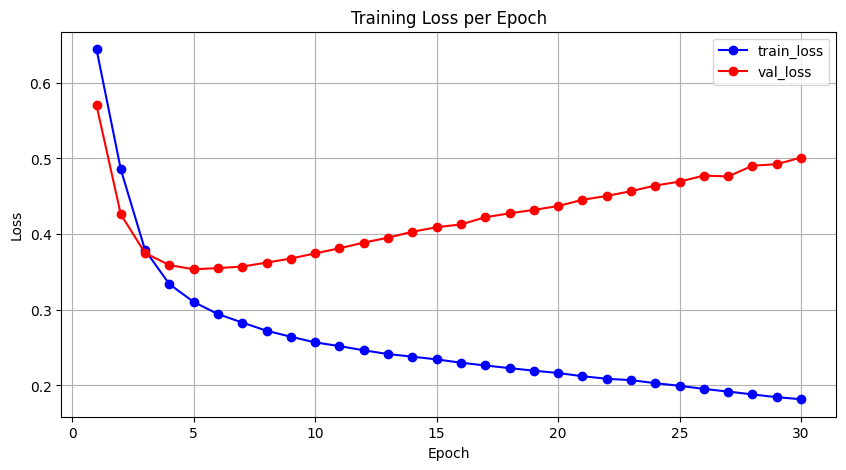

In [81]:
import matplotlib.pyplot as plt

num_epochs = 30  # Number of epochs
losses = []  # List to store the average loss per epoch
val_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0  # Variable to store the total loss in each epoch
    total_val_loss = 0
    count = 0  # Variable to count the number of batches
    val_count = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()  # Squeeze the output to match the label's shape
        loss = criterion(outputs, labels.float())  # Ensure labels are float
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count += 1
    average_loss = total_loss / count  # Calculate average loss for the epoch
    losses.append(average_loss)  # Append average loss to the list
       
    for inputs, labels in val_loader:
        val_outputs = model(inputs)
        val_outputs = val_outputs.squeeze()  # Squeeze the output to match the label's shape
        val_loss = criterion(val_outputs, labels.float())  # Ensure labels are float
        total_val_loss += val_loss.item()
        val_count += 1
    average_val_loss = total_val_loss / val_count  # Calculate average loss for the epoch
    val_losses.append(average_val_loss)  # Append average loss to the list
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}')

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses, marker='o', linestyle='-', color='b', label = 'train_loss')
plt.plot(range(1, num_epochs + 1), val_losses, marker='o', linestyle='-', color='r', label = 'val_loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Observations-
1. The train loss is decreasing with each epoch while the loss for validation reaches its minima at the 5th epoch and then starts to rise. One way  to prevent overfitting could have been to stop the training at the 4th or 5th epoch. Feel free to try it yourself.

In [79]:
def calculate_accuracy(loader):
    model.eval()  # Set the model to evaluation mode
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            predicted = outputs.squeeze() > 0.5  # Apply threshold to convert probabilities to binary predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

train_accuracy = calculate_accuracy(train_loader)
val_accuracy = calculate_accuracy(val_loader)

print(f'Training Accuracy: {train_accuracy}%')
print(f'Validation Accuracy: {val_accuracy}%')


Training Accuracy: 95.32360015662583%
Validation Accuracy: 82.64160793526494%
